In [2]:
import boto3
import awswrangler as wr
import pandas as pd
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"

In [11]:
text_df = wr.s3.read_parquet(s3_collection_path + "seekingAlpha.seekingAlphaAnalysisPosts/2023-09-28.parquet", boto3_session=session)
df = wr.s3.read_parquet(s3_collection_path + "seekingAlpha.seekingAlphaBulkMetrics/2023-09-28.parquet", boto3_session=session)

In [12]:
text_df.shape, df.shape

((579, 19), (1570, 265))

In [13]:
text_df["ticker"].unique()

<StringArray>
[   'A',   'AA', 'AAPL', 'ABCL', 'ACAD', 'ACDC', 'ACHR',  'ACI', 'ACLS',
  'ADC',
 ...
  'WMT',  'WPC',   'WY',  'XEL',  'XOM',    'Z',  'ZIM',   'ZM',   'ZS',
  'ZTS']
Length: 345, dtype: string

In [14]:
text_df["ticker"].value_counts()

ticker
WPC     11
NVDA     9
UBER     8
AAPL     8
DIS      7
        ..
S        1
SABR     1
SAFE     1
SBAC     1
ZTS      1
Name: count, Length: 345, dtype: Int64

In [15]:
new_analysis_counts = text_df["ticker"].value_counts().reindex(df["ticker"], fill_value=0)
new_analysis_counts.head()

ticker
A       1
AA      1
AAL     0
AAP     0
AAPL    8
Name: count, dtype: Int64

In [16]:
df = df.set_index('ticker')

In [17]:
df["new_analysis_count"] = new_analysis_counts

In [18]:
df["new_analysis_count"].head()

ticker
A       1
AA      1
AAL     0
AAP     0
AAPL    8
Name: new_analysis_count, dtype: Int64

In [19]:
text_df.columns

Index(['date', 'title', 'url', 'numComments', 'author_name', 'author_url',
       'title_neg', 'title_neu', 'title_pos', 'title_compound', 'summary_neg',
       'summary_neu', 'summary_pos', 'summary_compound', 'content_neg',
       'content_neu', 'content_pos', 'content_compound', 'ticker'],
      dtype='object')

In [20]:
float_df = text_df.select_dtypes([int, float])
float_df["ticker"] = text_df["ticker"]
analysis_df = float_df.groupby("ticker").mean().reindex(df.index, fill_value=0.)

In [22]:
new_df = pd.concat([df, analysis_df], axis = 1)
new_df.shape

(1570, 278)

In [23]:
df_guru = wr.s3.read_parquet(s3_collection_path + "gurufocus/2023-09-28.parquet", boto3_session=session)

In [24]:
df_guru = df_guru.set_index("symbol")

In [25]:
full_df = pd.concat([new_df, df_guru], axis = 1)
full_df.shape

(1570, 347)

In [26]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    # plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    # plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    return fig

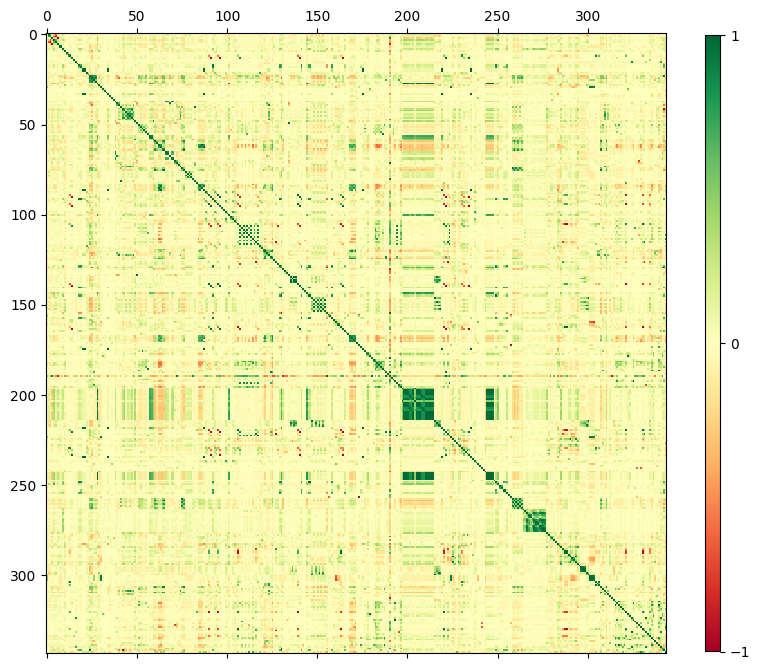

In [27]:
plot_corr(full_df.select_dtypes(float))
pass

In [28]:
float_df = full_df.select_dtypes([int, float])

In [29]:
import scipy
import numpy as np
import scipy.cluster.hierarchy as sch

float_df = float_df.fillna(0.)

X = float_df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [float_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
float_df = float_df.reindex(columns = columns)


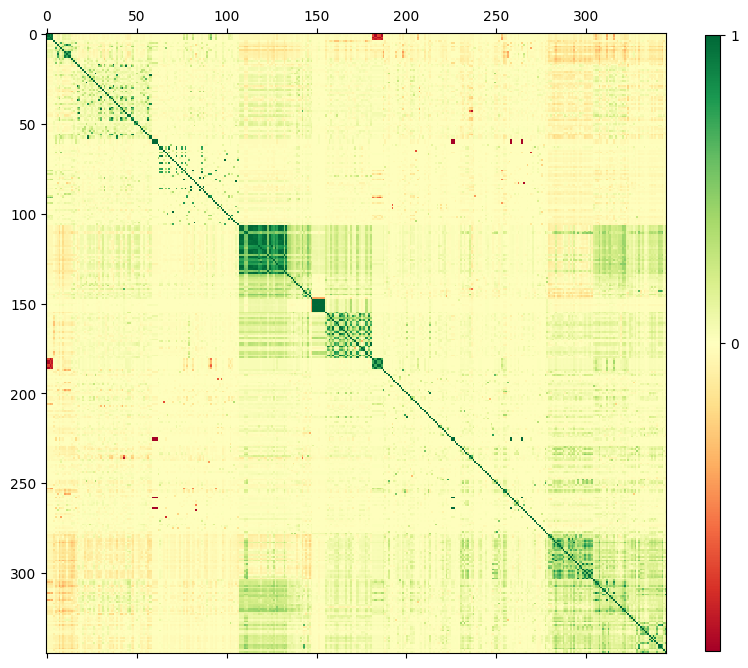

In [30]:
plot_corr(float_df)
pass

In [31]:
corr_df = float_df.corr()

In [32]:
corr_df.abs().mean(axis = 1).sort_values(ascending = False).head(50)

Years_of_Profitability_over_Past_10-Year    0.162250
profitability_rank                          0.160298
log_of_unadjusted_stock_price               0.149462
price_low_52w                               0.148234
close                                       0.148156
sma_200d                                    0.148108
price_close_1w                              0.148048
price_close_adj_1w                          0.148045
sma_10d                                     0.148036
price_close_6m                              0.147924
price_close_1y                              0.147865
sma_100d                                    0.147779
price_close_adj_6m                          0.147757
price_close_1m                              0.147691
price_close_adj_1m                          0.147684
sma_50d                                     0.147661
price_close_adj_1y                          0.147500
price_close_ytd                             0.147233
price_close_adj_ytd                         0.

In [33]:
corr_df.abs().mean(axis = 1).sort_values(ascending = False).tail(50)

ev_ebit                              0.023457
dividend_lt_fwd_growth               0.023431
net_lt_debt_ebitda_avg_5y            0.023274
return_on_net_tangible_assets        0.023219
net_inc_per_employee_avg_5y          0.022978
div_payout_nongaap_fy1_avg_5y        0.022647
int_cover_avg_5y                     0.021951
Price-to-Free-Cash-Flow              0.021602
price_cf_ratio_fy1                   0.021513
diluted_eps_growth                   0.020559
operating_income_ebit_yoy_avg_5y     0.020547
op_cf_yoy_avg_5y                     0.020512
dps_yoy_avg_5y                       0.020441
working_cap_change_avg_5y            0.020347
div_coverage_ratio_fy1               0.020006
EV-to-Forward-EBIT                   0.019749
ev_ebitda                            0.019448
pe_gaap_fy1                          0.019327
ev_ebit_fy1                          0.019312
debt_eq_avg_5y                       0.019286
net_lt_debt_ebitda                   0.019077
gross_margin_avg_5y               

In [34]:
corr_df.loc["numComments"].sort_values().tail(20)

marketcap_display           0.184462
div_yield_fwd               0.187224
ebitda                      0.189820
Forward_Dividend_Yield_%    0.190740
div_yield_4y                0.193637
tev                         0.199919
title_neg                   0.212658
summary_compound            0.272218
title_pos                   0.278908
summary_neg                 0.308277
summary_pos                 0.339652
content_compound            0.387357
content_pos                 0.433108
authors_count               0.446510
content_neg                 0.469760
title_neu                   0.474888
content_neu                 0.478212
summary_neu                 0.490863
new_analysis_count          0.529803
numComments                 1.000000
Name: numComments, dtype: float64

In [35]:
corr_df["fcf_yield"].abs().mean()

0.017149411344662965

In [63]:
from scipy.stats import skew, kurtosis

In [64]:
from sklearn.preprocessing import normalize
from tqdm import tqdm

In [65]:
normalized_df = pd.DataFrame(
	normalize(full_df.select_dtypes([int, float]).fillna(0.)),
	index=full_df.index,
	columns=full_df.select_dtypes([int, float]).columns)

normalized_df.head()


,altman_z_score,analysts_down,analysts_down_percent,analysts_down_percent_avg_5y,analysts_up,analysts_up_percent,analysts_up_percent_avg_5y,assets_turnover,assets_turnover_avg_5y,authors_count,...,Price-to-Median-PS-Value,Price-to-Peter-Lynch-Fair-Value,Price-to-Graham-Number,Earnings_Yield__Greenblatt__%,Forward_Rate_of_Return__Yacktman__%,Price-to-DCF__Earnings_Based_,Price-to-DCF__FCF_Based_,Price-to-Net-Current-Asset-Value,Price-to-Net-Cash,Price-to-FFO
A,1.065985e-10,2.598635e-10,1.732423e-09,2.210436e-10,0.000000e+00,0.000000e+00,1.511380e-09,1.145286e-11,1.042066e-11,6.929693e-11,...,1.697775e-11,3.412874e-11,1.093159e-10,7.536041e-11,3.113165e-10,0.000000e+00,0.000000e+00,0.0,0.0,0.0
AA,9.258501e-11,4.625170e-10,6.607386e-09,3.991167e-09,0.000000e+00,0.000000e+00,2.616219e-09,4.813421e-11,5.008232e-11,1.321477e-10,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.376319e-09,-9.382488e-11,0.000000e+00,0.000000e+00,0.0,0.0,0.0
AAL,1.053408e-11,1.099355e-10,6.466795e-10,6.595130e-10,9.772046e-11,5.748263e-10,5.619928e-10,9.556109e-12,7.321165e-12,8.550541e-11,...,4.641722e-12,0.000000e+00,0.000000e+00,1.755304e-10,-3.339597e-10,0.000000e+00,0.000000e+00,0.0,0.0,0.0
AAP,1.414907e-10,9.365371e-10,6.243581e-09,2.452159e-09,0.000000e+00,0.000000e+00,3.791422e-09,5.731457e-11,5.806184e-11,4.994865e-10,...,1.560895e-11,7.117682e-11,6.930374e-11,4.632737e-10,1.274315e-09,5.182172e-11,0.000000e+00,0.0,0.0,0.0
AAPL,1.657545e-12,1.735745e-12,4.821515e-12,5.193146e-12,6.075109e-12,1.687530e-11,1.650367e-11,2.481615e-13,2.016029e-13,7.810854e-12,...,3.970517e-13,3.384703e-13,1.631601e-12,9.221147e-13,4.621422e-12,2.798889e-13,2.755496e-13,0.0,0.0,0.0


In [73]:
column_skews = pd.Series([skew(normalized_df[c].astype("float")) for c in normalized_df.columns], index=normalized_df.columns)
column_kurtosis = pd.Series([kurtosis(normalized_df[c].astype("float"), fisher=False) for c in normalized_df.columns], index=normalized_df.columns)

Text(0.5, 0, 'Skew')

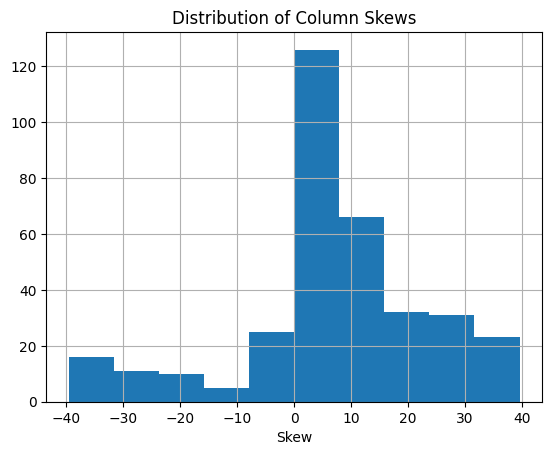

In [74]:
import matplotlib.pyplot as plt

column_skews.hist()
plt.title("Distribution of Column Skews")
plt.xlabel("Skew")

Text(0.5, 0, 'Kurtosis')

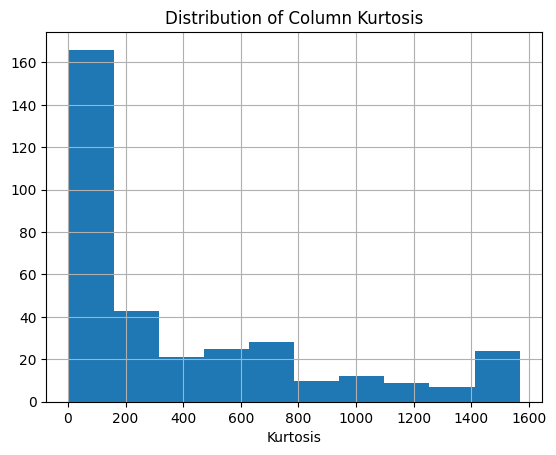

In [75]:
column_kurtosis.hist()
plt.title("Distribution of Column Kurtosis")
plt.xlabel("Kurtosis")

In [79]:
column_skews.abs().sort_values(ascending=False).head(50)

diluted_eps_growth_avg_5y           39.583904
rtn_on_common_equity_avg_5y         39.570077
revenue_growth                      39.545669
pe_ratio                            39.538203
capex_to_sales_avg_5y               39.522330
revenue_per_share                   39.514034
capex_change                        39.469740
ebitda_margin_avg_5y                39.436790
ebit_margin_avg_5y                  39.434228
ps_ratio_avg_5y                     39.296136
net_margin_avg_5y                   39.221931
revenue_growth_avg_5y               39.011518
return_on_avg_tot_assets_avg_5y     38.960750
fcf_yield                           38.941539
peg_gaap                            38.919424
levered_fcf_margin_avg_5y           38.841254
eps_gaap_annual_growth_yoy          38.736410
rtn_on_common_equity                38.149296
EV-to-Forward-EBIT                  38.013656
Price-to-Tangible-Book              37.565511
net_lt_debt_ebitda_avg_5y           37.470231
div_coverage_ratio_fy1            

In [81]:
column_kurtosis.abs().sort_values(ascending=False).tail(50)

div_yield_div_payout_avg_5y                 23.038780
dividend_consistency_avg_5y                 22.898785
cash_from_operations_as_reported            22.497815
div_consistency_category                    22.336102
price_high_52w                              21.617480
sma_200d                                    21.559264
div_yield_div_payout                        21.047256
analysts_up                                 20.789456
price_close_adj_1y                          20.384043
price_close_1y                              20.023233
earnings_yield                              19.879668
oper_income_fy1_market_cap                  19.322722
total_cash                                  18.393385
sma_100d                                    18.187804
analysts_down                               18.104502
net_income                                  17.449580
sma_50d                                     16.207438
price_close_adj_1m                          16.037422
price_close_1m              